In [1]:
import torch
import torchinfo
import torchvision
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torch.cuda.amp import autocast,GradScaler
from torchvision.models.resnet import BasicBlock
from tensorboardX import SummaryWriter

In [2]:
import os
import cv2
import PIL
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from typing import Tuple,List,Dict
from xml.etree import cElementTree as etree

In [3]:
class conv3x3(nn.Module):
    
    def __init__(self,in_channels,out_channels,stride=1):
        super(conv3x3,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,(3,3),stride=stride,padding=1)
#         self.bn = nn.BatchNorm2d(out_channels)
        nn.init.trunc_normal_(self.conv.weight,mean=0.0,std=0.01)
        
    def forward(self,x):
        tmp = self.conv(x)
#         tmp = self.bn(tmp)
        tmp = F.leaky_relu(tmp,0.1,inplace=True)
        return tmp

In [4]:
class conv1x1(nn.Module):
    
    def __init__(self,in_channels,out_channels,stride=1):
        super(conv1x1,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,(1,1),stride=stride)
#         self.bn = nn.BatchNorm2d(out_channels)
        nn.init.trunc_normal_(self.conv.weight,mean=0.0,std=0.01)
        
    def forward(self,x):
        tmp = self.conv(x)
#         tmp = self.bn(tmp)
        tmp = F.leaky_relu(tmp,0.1,inplace=True)
        return tmp

In [5]:
class yolov1(nn.Module):
    
    def __init__(self):
        super(yolov1,self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(3,64,(7,7),stride=2,padding=3),
#             nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2),stride=2)
        )
        self.conv_2 = nn.Sequential(
            conv3x3(64,192),
            nn.MaxPool2d((2,2),stride=2)
        )
        self.conv_3 = nn.Sequential(
            conv1x1(192,128),
            conv3x3(128,256),
            conv1x1(256,256),
            conv3x3(256,512),
            nn.MaxPool2d((2,2),stride=2)            
        )
        self.conv_4 = nn.Sequential(
            conv1x1(512,256),
            conv3x3(256,512),
            conv1x1(512,256),
            conv3x3(256,512),
            conv1x1(512,256),
            conv3x3(256,512),
            conv1x1(512,256),
            conv3x3(256,512),
            conv1x1(512,512),
            conv3x3(512,1024),
            nn.MaxPool2d((2,2),stride=2)            
        )
        self.conv_5 = nn.Sequential(
            conv1x1(1024,512),
            conv3x3(512,1024),
            conv1x1(1024,512),
            conv3x3(512,1024), # end of backbone
            conv3x3(1024,1024),
            conv3x3(1024,1024,stride=2)
        )
        self.conv_6 = nn.Sequential(
            conv3x3(1024,1024),
            conv3x3(1024,1024)
        )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(7*7*1024,4096),
#             nn.Dropout(p=.5),
#             nn.LeakyReLU(0.1),
#             nn.Linear(4096,7*7*30),
#         )
        self.conv_out = nn.Sequential(
            conv3x3(1024,1024),
#             nn.Dropout(p=.5),
            nn.Conv2d(1024,30,(1,1),stride=1)
        )

        
    def forward(self,x):
        tmp = self.conv_1(x) # 112 x 112 x 64 # conv stride 2 will reduce hw 2 times too
        tmp = self.conv_2(tmp) # 56 X 56 X 192
        tmp = self.conv_3(tmp) # 28 x 28 x 512
        tmp = self.conv_4(tmp) # 14 x 14 x 1024
        tmp = self.conv_5(tmp) # 7 x 7 x 1024 # conv stride 2 will reduce hw 2 times too
        tmp = self.conv_6(tmp) # 7 x 7 x 1024
        
        tmp = self.conv_out(tmp)
        
#         tmp = torch.flatten(tmp,start_dim=1)
#         tmp = self.classifier(tmp)
#         tmp = tmp.reshape(-1,30,7,7)#.contiguous()
        
        return tmp

In [6]:
class yolov1_resnet(nn.Module):
    
    def __init__(self, layer:int):
        super(yolov1_resnet,self).__init__()
        if layer == 18:
            self.backbone = torchvision.models.resnet18(pretrained=True)
        elif layer == 34:
            self.backbone = torchvision.models.resnet34(pretrained=True)
        elif layer == 50:
            self.backbone = torchvision.models.resnet50(pretrained=True)
        else:
            raise NotImplementedError
            
        self.backbone.fc = nn.Identity()
        
        # as paper suggested, deeper conv layer
        in_ch = 512 if layer != 50 else 2048
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch,1024,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,3,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024,1024,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )
        
#         self.conv = self.backbone._make_layer(BasicBlock, 1024, 2, stride=2)
                
        # too much parameters, over one fourth billion
#         self.classifier = nn.Sequential(
#             nn.Linear(7*7*512,1024),
#             nn.Dropout(p=.5),
#             nn.LeakyReLU(0.1),
#             nn.Linear(1024,7*7*30),
#         )

        self.conv_out = nn.Sequential(
            nn.Conv2d(1024,30,(1,1),stride=1)
        )

        
    def forward(self,x):
        tmp = self.backbone.conv1(x)
        tmp = self.backbone.bn1(tmp)
        tmp = self.backbone.relu(tmp)
        tmp = self.backbone.maxpool(tmp)
        tmp = self.backbone.layer1(tmp)
        tmp = self.backbone.layer2(tmp)
        tmp = self.backbone.layer3(tmp)
        tmp = self.backbone.layer4(tmp)
        
        tmp = self.conv(tmp)
        tmp = self.conv_out(tmp)
        
#         tmp = torch.flatten(tmp,start_dim=1)
#         tmp = self.classifier(tmp)
#         tmp = tmp.reshape(-1,30,7,7)#.contiguous()
        
        return tmp

In [26]:
torchinfo.summary(yolov1(), input_size=(64, 3, 448, 448))

Layer (type:depth-idx)                   Output Shape              Param #
yolov1                                   --                        --
├─Sequential: 1-1                        [64, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [64, 64, 224, 224]        9,472
│    └─MaxPool2d: 2-2                    [64, 64, 112, 112]        --
├─Sequential: 1-2                        [64, 192, 56, 56]         --
│    └─conv3x3: 2-3                      [64, 192, 112, 112]       --
│    │    └─Conv2d: 3-1                  [64, 192, 112, 112]       110,784
│    └─MaxPool2d: 2-4                    [64, 192, 56, 56]         --
├─Sequential: 1-3                        [64, 512, 28, 28]         --
│    └─conv1x1: 2-5                      [64, 128, 56, 56]         --
│    │    └─Conv2d: 3-2                  [64, 128, 56, 56]         24,704
│    └─conv3x3: 2-6                      [64, 256, 56, 56]         --
│    │    └─Conv2d: 3-3                  [64, 256, 56, 56]         295,16

In [22]:
#模型測試
torch.testing.assert_equal(yolov1()(torch.randn(1,3,448,448)).shape,torch.Size([1, 30, 7, 7]))

In [23]:
#模型測試
torch.testing.assert_equal(yolov1_resnet(18)(torch.randn(1,3,448,448)).shape,torch.Size([1, 30, 7, 7]))
torch.testing.assert_equal(yolov1_resnet(34)(torch.randn(1,3,448,448)).shape,torch.Size([1, 30, 7, 7]))
torch.testing.assert_equal(yolov1_resnet(50)(torch.randn(1,3,448,448)).shape,torch.Size([1, 30, 7, 7]))

In [7]:
def generate_grid_train(grid_size: Tuple[int, int]) -> torch.Tensor:
    # recover x,y coord since we use x,y offset
    grid_x, grid_y = grid_size
    y_offset, x_offset = torch.meshgrid(torch.arange(grid_x),torch.arange(grid_y))    
    
    grid_tmp = torch.cat([x_offset.unsqueeze(0),y_offset.unsqueeze(0)],dim=0) # 2, 7, 7

    grid_tmp = grid_tmp.unsqueeze(0)/grid_size[0] # 1, 2, 7 ,7 # to relative
    
    return grid_tmp

In [8]:
def xywh_to_xyxy(coord: torch.Tensor) -> torch.Tensor:
    # convert xywh to xyxy
    b, _, sx, sy = coord.shape
    d = 'cuda:0' if coord.is_cuda else 'cpu'
    grid_for_train = generate_grid_train((sx,sy)).repeat(b,1,1,1).to(d) 
    xy = coord[:,0:2,:,:]+grid_for_train # B, 2, 7, 7
    wh = coord[:,2:4,:,:] # B, 2, 7, 7 

    return torch.cat([xy-wh/2,xy+wh/2],dim=1) # B, 4, 7, 7

In [9]:
def IOU(cbox1: torch.Tensor, cbox2: torch.Tensor) -> torch.Tensor:
    """
    input: x_offset y_offset wh format
    output: iou for each batch and grid cell
    """
    
    # prevent zero division since most of grid cell are zero area
    epsilon = 1e-10
    
    # coord_conversion
    box1 = xywh_to_xyxy(cbox1) # B, 4, 7, 7
    box2 = xywh_to_xyxy(cbox2)
    
    # find intersection
    x1 = torch.max(box1[:,0:1,:,:],box2[:,0:1,:,:])
    y1 = torch.max(box1[:,1:2,:,:],box2[:,1:2,:,:])
    x2 = torch.min(box1[:,2:3,:,:],box2[:,2:3,:,:])
    y2 = torch.min(box1[:,3:4,:,:],box2[:,3:4,:,:])
    
    intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0) # N, 1, 7, 7
    
    total_area = (cbox1[:,2:3,:,:]*cbox1[:,3:4,:,:]).abs() + cbox2[:,2:3,:,:]*cbox2[:,3:4,:,:] - intersection # N, 1, 7, 7
    
    assert intersection.ge(0).all(), 'intersection should be more than 0'
    assert total_area.ge(0).all(), 'total area should be more than 0'
    
    # compute iou
    value = intersection/(total_area+epsilon)
    
    return value

In [10]:
class YoloLoss(nn.Module):
    
    def __init__(self, lambda_coord = 5, lambda_noobject = 0.5):
        super(YoloLoss,self).__init__()
        
        self.grid_size = IMAGE_SIZE/64
        self.num_bbox = NUM_BOXES
        self.lambda_coord = lambda_coord
        self.lambda_noobject = lambda_noobject
        self.epsilon = 1e-5
        
    def iou_box(self, prediction: torch.Tensor, groundtruth: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        with torch.no_grad():
            ious = [IOU(prediction[:,(1+5*b):(5+5*b),:,:],groundtruth[:,1:5,:,:]) for b in range(self.num_bbox)]
        ious = torch.cat(ious,dim=1) # N, boxes, 7, 7
        max_iou, best_box = ious.max(dim=1,keepdim=True) # N,1,7,7
        return max_iou, best_box
        
    def forward(self, prediction: torch.Tensor, groundtruth: torch.Tensor) -> torch.Tensor:
        groundtruth = groundtruth.float()
        
        # obj indicator
        obj_here = groundtruth[:,0:1,:,:] # [N,1,7,7]
        
        # iou indicator
        ious, best_box = self.iou_box(prediction, groundtruth) # N, 1, 7, 7
                  
        # left only 49 predictors
        box_pred = torch.zeros_like(prediction[:,:5,:,:]) # N, 5, 7, 7
        for b in range(self.num_bbox): box_pred += best_box.eq(b) * prediction[:,b*5:(b+1)*5,:,:]
        cls_pred = prediction[:,self.num_bbox*5:,:,:]
        wh_pred = box_pred[:,3:5,:,:].sign() * (box_pred[:,3:5,:,:].abs()+self.epsilon).sqrt() # sqrt the value then plus sign back
        
        # class loss objecness loss and xywh loss                
        # indicator has to be inside the loss function
        cls_loss = F.mse_loss(obj_here*cls_pred, groundtruth[:,5:,:,:],reduction="sum")
        obj_loss = F.mse_loss(obj_here*box_pred[:,0:1,:,:], obj_here*ious,reduction="sum")
        xy_loss = F.mse_loss(obj_here*box_pred[:,1:3,:,:], groundtruth[:,1:3,:,:],reduction="sum")
        wh_loss = F.mse_loss(obj_here*wh_pred, groundtruth[:,3:5,:,:].sqrt(),reduction="sum")
        
        # not mention in the original papaer, but in aladdin and clean the other bbox block with wrong confidence
        noobj_loss = 0.0
        for b in range(self.num_bbox):
            noobj_loss += F.mse_loss((1-obj_here)*prediction[:,0+5*b:1+5*b,:,:], obj_here*0,reduction="sum") # weird part 
        
        total_loss = cls_loss + self.lambda_noobject * noobj_loss + obj_loss + self.lambda_coord * (xy_loss + wh_loss)

        return total_loss

In [11]:
class VOC_dataset(torch.utils.data.Dataset):
    
    def __init__(self, root, year='2012', mode='train', transform=None, grid_size=7, num_classes=20):
        list_path = [(os.path.join(root,f'VOCdevkit/VOC{y}/ImageSets/Main/{mode}.txt'),y) for y in year.split('+')]
#         label_path = [(os.path.join(root,f'VOCdevkit/VOC{y}/Annotations'),y) for y in year.split('+')]

        self.root = root
        self.year = year
        self.mode = mode
        self.grid_size = grid_size
        self.num_classes = num_classes
        self.transform = transform
        self.labels = []
        for p,y in list_path:
            with open(p,'r') as f:
                p = [os.path.join(root,f'VOCdevkit/VOC{y}/Annotations',f'{g.strip()}.xml') for g in f.readlines()]
                self.labels += p
#                 self.labels += glob(os.path.join(p,'*.xml'))
#         self.testimg = []
            
    def __len__(self):
        return len(self.labels)

    
    def get_img(self, idx):
        jpg = self.labels[idx].replace('Annotations','JPEGImages').replace('xml','jpg')
            
        img = PIL.Image.open(jpg).convert('RGB')
        w,h = img.size
        if self.transform: img = self.transform(img)       
        
        return img,h,w
    
    def get_label(self,idx,h,w):
        xml = self.labels[idx]
        tree = etree.parse(xml)
        label = self.process_label(tree,h,w)
        
        return label
    
    def process_label(self,tree,img_h,img_w):
        tree = tree.findall('object')
        
        label = np.zeros((5+self.num_classes,self.grid_size,self.grid_size))

        for obj in tree:
            if obj.find('difficult').text == '1': continue
            bbox = obj.find('bndbox')

            xmin = float(bbox.find('xmin').text)
            xmax = float(bbox.find('xmax').text)
            ymin = float(bbox.find('ymin').text)
            ymax = float(bbox.find('ymax').text)

            w = (xmax-xmin)/img_w
            h = (ymax-ymin)/img_h

            class_ind = voc_classes.index(obj.find('name').text)

            cx = (xmin+xmax)/2/img_w
            cy = (ymin+ymax)/2/img_h
            x = (cx % (1/self.grid_size)) # left offset
            y = (cy % (1/self.grid_size)) # top offset

            x_ind = int(cx*self.grid_size)
            y_ind = int(cy*self.grid_size)
            label[0,y_ind,x_ind] = 1
            label[1:5,y_ind,x_ind] = [x,y,w,h]
            label[5+class_ind,y_ind,x_ind] = 1

        label = torch.from_numpy(label)
        
        return label
    
    def __getitem__(self, idx):        
        img,h,w = self.get_img(idx)
        label = self.get_label(idx,h,w) #if self.mode != 'test' else None
        
        return img, label

# setting

In [12]:
torch.backends.cudnn.benchmark=True

In [13]:
MODEL_BACKBONE = 'resnet34'

if MODEL_BACKBONE == 'yolov1':
    BATCH_SIZE = 64
    ACC_ITER = 1
elif MODEL_BACKBONE == 'resnet18':
    BATCH_SIZE = 32
    ACC_ITER = 2
elif MODEL_BACKBONE == 'resnet34':
    BATCH_SIZE = 16
    ACC_ITER = 4
elif MODEL_BACKBONE == 'resnet50':
    BATCH_SIZE = 8
    ACC_ITER = 8
    
IMAGE_SIZE = 448
device = 'cuda:0'
NUM_BOXES = 2

In [14]:
voc_classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
            "bus", "car", "cat", "chair", "cow", "diningtable",
            "dog", "horse", "motorbike", "person", "pottedplant",
            "sheep", "sofa", "train", "tvmonitor"]

In [15]:
preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
#     transforms.ColorJitter(1.5,1.5,1.5,0),
    transforms.ToTensor(),
])

In [16]:
preprocess2 = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [17]:
# lift could be easier with torchvision.datasets.VOCDetection

In [18]:
trainset = VOC_dataset('../data', year='2012+2007', mode='trainval', transform=preprocess)
testset = VOC_dataset('../data', year='2007', mode='test', transform=preprocess2)

In [19]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE,shuffle=False)

In [20]:
if MODEL_BACKBONE.startswith('resnet'):
    layer_num = int(MODEL_BACKBONE[6:])
    model = yolov1_resnet(layer_num).to(device)
elif MODEL_BACKBONE == 'yolov1':
    model = yolov1().to(device)

In [21]:
criterion = YoloLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lr_lambda=[lambda e: 1e-4 if e < 50 else 5e-5])
# scaler = GradScaler() # amp

In [22]:
writer = SummaryWriter()

# training

In [24]:
def train(e):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad(set_to_none=True)
    for i, data in enumerate(tqdm(trainloader)):

        img, label = data
        
        img= img.to(device) 
        label = label.to(device) 

#         with autocast():
        output = model(img)
        loss = criterion(output,label)
        loss = loss/ACC_ITER
        
        loss.backward()
        
        if i % ACC_ITER == 0:
#             scheduler.step()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()

        running_loss += loss.item()
        
        assert not np.isnan(running_loss), 'loss died'
        
        # print loss every 100 batch
        if (i+1) % 100 == 0: 
            print(running_loss/(i+1)/BATCH_SIZE)
        
        training_loss_history.append(loss.item())
        writer.add_scalar('training loss', loss.item(), i+e*len(trainloader))

    
    if (e+1) % 10 == 0:
        torch.save(model.state_dict(),f'yolov1.{MODEL_BACKBONE}.{e+1}.pth')
            
    print(f'epoch {e+1} : {running_loss/len(trainset)}')

In [ ]:
training_loss_history = []
epoches = 100
for epoch in range(0,epoches):
    train(epoch)

  0%|                                                                                         | 0/1035 [00:00<?, ?it/s]C:\Users\User\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 10%|███████▋                                                                       | 100/1035 [00:40<06:03,  2.57it/s]

4.193220304250717


 19%|███████████████▎                                                               | 200/1035 [01:19<05:24,  2.57it/s]

2.622392114698887


 24%|██████████████████▋                                                            | 245/1035 [01:36<05:13,  2.52it/s]

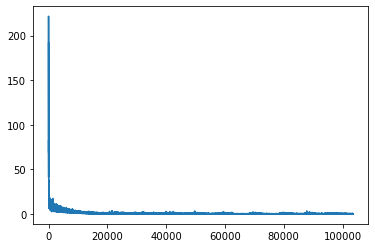

In [26]:
plt.plot(training_loss_history)

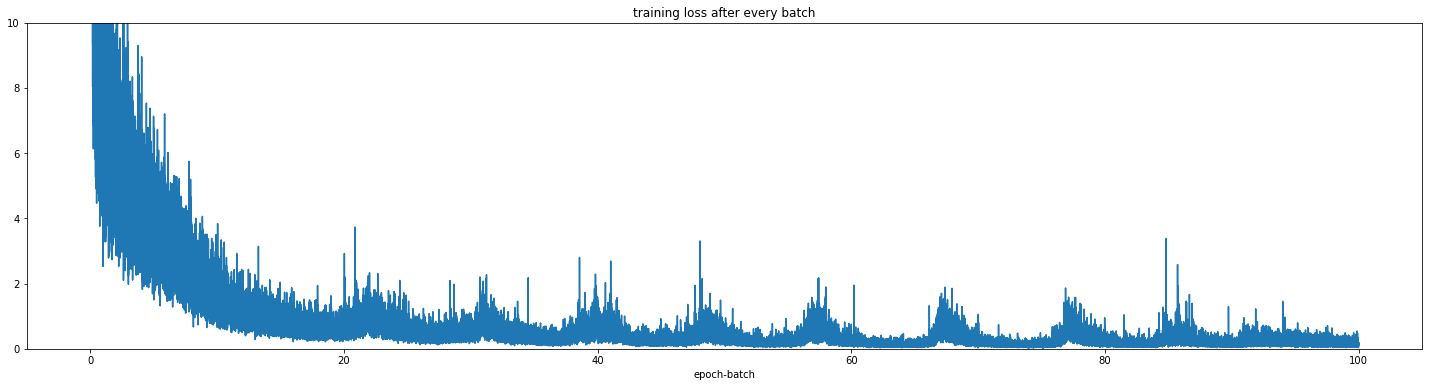

In [27]:
plt.figure(figsize=(25,6))
# plt.xlim(0,10)
plt.ylim(0,10)
plt.title('training loss after every batch')
plt.xlabel('epoch-batch')
timeline = [j+i/len(trainloader) for j in range(int(len(training_loss_history)/len(trainloader))) for i in range(len(trainloader))]
plt.plot(timeline, np.array(training_loss_history))
# plt.plot(training_loss_history)

In [ ]:
# training requires day
4.5*100/1440

In [28]:
writer.close()

# save & load

In [26]:
# test if output degenerate
a,b = trainset[0][0],trainset[100][0]
print(a.eq(b).all())
a_x, b_x = model(a.unsqueeze(0).to(device)), model(b.unsqueeze(0).to(device))
print(a_x.eq(b_x).all())

tensor(False)
tensor(False, device='cuda:0')


In [ ]:
# manual save carefully, if you have many checkpoints
torch.save(model.state_dict(),f'yolov1.{MODEL_BACKBONE}.10.pth')    

In [50]:
# load carefully, if you have many checkpoints
model.load_state_dict(torch.load(f'yolov1.{MODEL_BACKBONE}.10.pth'))

# decode

In [29]:
def generate_grid(grid_size: Tuple[int]) -> torch.Tensor:
    grid_x, grid_y = grid_size
    y_offset, x_offset = torch.meshgrid(torch.arange(grid_x),torch.arange(grid_y))
    
    return x_offset, y_offset

In [30]:
def yolov1_decode(featuremap: torch.Tensor, model_image_size: Tuple[int, int], num_classes: int, num_anchors: int) -> torch.Tensor:
    
    batch_size, channel_size, fm_h, fm_w = featuremap.shape
    input_h, input_w = model_image_size
    stride_x, stride_y = input_w/fm_w, input_h/fm_h
    num_bbox = int((channel_size - num_classes)/5)
    
    grid_x, grid_y = generate_grid((fm_w,fm_h))

    bbox_info = []
    for b in range(num_bbox):
        # batch_size, 1, grid_size x grid_size
        cx = (featuremap[:,(1+5*b):(2+5*b),:,:]*input_w+grid_x*stride_x).reshape(batch_size,1,-1) 
        cy = (featuremap[:,(2+5*b):(3+5*b),:,:]*input_h+grid_y*stride_y).reshape(batch_size,1,-1)
        w = (featuremap[:,(3+5*b):(4+5*b),:,:]*input_w).reshape(batch_size,1,-1) 
        h = (featuremap[:,(4+5*b):(5+5*b),:,:]*input_h).reshape(batch_size,1,-1)
        conf = featuremap[:,0+5*b,:,:].reshape(batch_size,1,-1)
        prob = featuremap[:,5*num_bbox:,:,:].reshape(batch_size,num_classes,-1)
        x = cx - w/2
        y = cy - h/2
                
        bbox_info.append(torch.cat([x,y,w,h,conf,prob],1))
        
    result = torch.cat(bbox_info,-1).transpose(1,2)

    return result

# visualization

In [31]:
def draw_pred(img:np.ndarray, bboxes: torch.Tensor, nms_index: torch.Tensor, class_show:bool):
    """draw predicted bbox"""
    
    for b in bboxes[0,nms_index,:]:
        x, y, w, h, c = b[:5]
        x, y, w, h = int(x), int(y), int(w), int(h)
        prob, cls_index = b[5:].max(dim=0)
        if prob*c > conf_thres:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)

            if class_show:
                cv2.rectangle(img,(x,y-30),(x+w,y),(0,0,255),-1)
                cv2.putText(img,voc_classes[cls_index.item()],(x+5,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),1)

In [32]:
# labels
def draw_label(img:np.ndarray, label: torch.Tensor):
    """draw detection label"""
    
    for i, (c,x,y,w,h) in enumerate(label[:5,:].reshape(5,-1).transpose(1,0)):
        if c:
            grid_x, grid_y = i%7, i//7
            cx, cy = grid_x*64+int(x*IMAGE_SIZE), grid_y*64+int(y*IMAGE_SIZE)
            w, h = int(w*IMAGE_SIZE) , int(h*IMAGE_SIZE)
            x, y = int(cx-w/2), int(cy-h/2)
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

In [33]:
def model_predict(img: torch.Tensor) -> torch.Tensor:
    
    with torch.no_grad():
        img = img.unsqueeze(0).to(device) if img.dim() == 3 else img.to(device)
        model.eval()
        pred = model(img)

        pred = pred.detach().cpu()
        img = img.detach().cpu()
    
    return pred

In [34]:
def nms(bbox: torch.Tensor, score: torch.Tensor, nms_thres: float, conf_thres: float) -> list:
    c_sort, sort_index = score.sort(descending=True)
    tmp_bbox = bbox[sort_index]

    best_index = []
    remove_index = []
    for i, (b,c) in enumerate(zip(tmp_bbox,c_sort)):
        if i==len(tmp_bbox)-1: break
        if i in remove_index: continue
        if conf_thres > c: continue
        x,y,w,h = b
        if w > 0 and h > 0 and c > 0 and 1 > c:
            best_index.append(sort_index[i].item())
            remove_index.append(i)
            b = torchvision.ops.box_convert(b.unsqueeze(0),'xywh','xyxy')
            other_b = torchvision.ops.box_convert(tmp_bbox[(i+1):],'xywh','xyxy')
            iou = torchvision.ops.box_iou(b,other_b)[0]
            over_index = iou.gt(nms_thres).nonzero().flatten().add(i+1).tolist()
            remove_index.extend(over_index)

    return best_index

In [35]:
def tensor2np_uint8(img: torch.Tensor) -> np.ndarray:
    assert img.dim() == 3, 'please provide tensor in shape C,H,W.'
    return (img.permute(1,2,0).numpy().copy()*255).astype(np.uint8)

In [36]:
conf_thres = 0.3
nms_thres = 0.5

In [55]:
testimg, labels = testset[1500]
testimgpred = model_predict(testimg)

In [56]:
bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1)

In [57]:
# torchvision.ops.nms worked wrongly, so my own version created
best_index = nms(bbox_result[0,:,:4],bbox_result[0,:,4], nms_thres, conf_thres)
print(len(best_index))

1


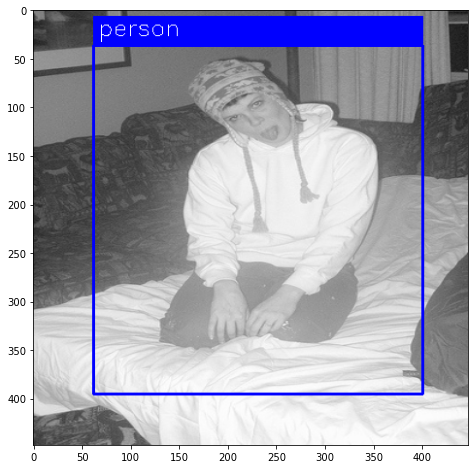

In [58]:
plt.figure(figsize=(8,8))
copy_img = tensor2np_uint8(testimg)
draw_pred(copy_img, bbox_result, best_index, class_show=True)
# draw_label(copy_img,labels)
plt.imshow(copy_img)

In [40]:
conf_thres = 0.3 # the lower, the more boxes
nms_thres = 0.5 # the higher, the more boxes

In [53]:
def lots_of_prediction(label_index: list):
    for i in label_index:
        testimg, labels = testset[i]
        testimgpred = model_predict(testimg)
        bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1)    
        best_index = nms(bbox_result[0,:,:4],bbox_result[0,:,4], nms_thres, conf_thres)
        
        plt.figure(figsize=(12,12))
        
        plt.subplot((131))
        copy_img = tensor2np_uint8(testimg)
        plt.imshow(copy_img)
        
        plt.subplot((132))
        copy_img = tensor2np_uint8(testimg)
        draw_label(copy_img, labels) 
        plt.imshow(copy_img)
        
        plt.subplot((133))
        copy_img = tensor2np_uint8(testimg)
        draw_pred(copy_img, bbox_result, best_index, class_show=True)
        plt.imshow(copy_img)

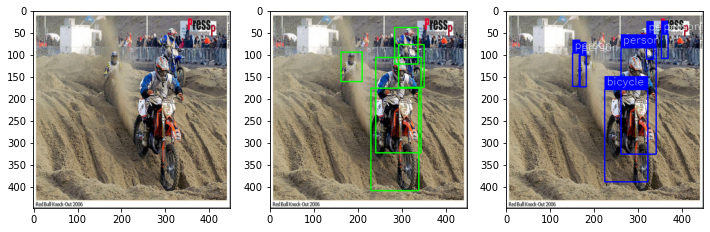

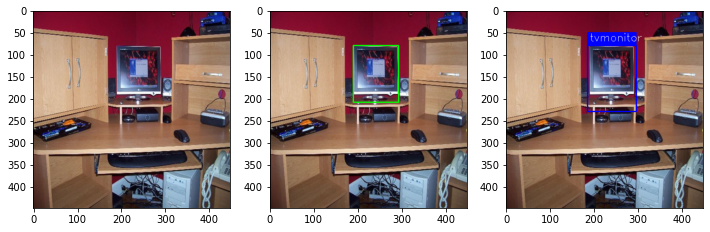

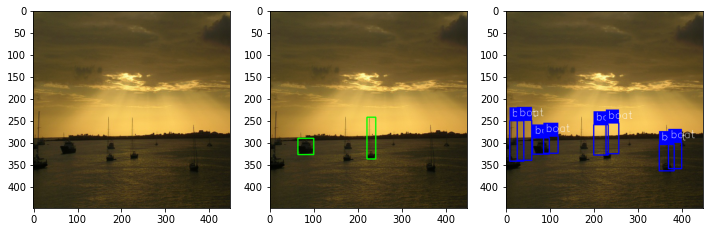

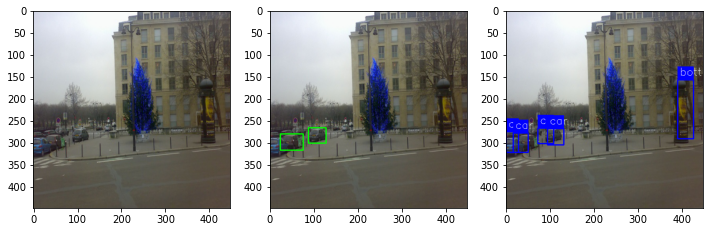

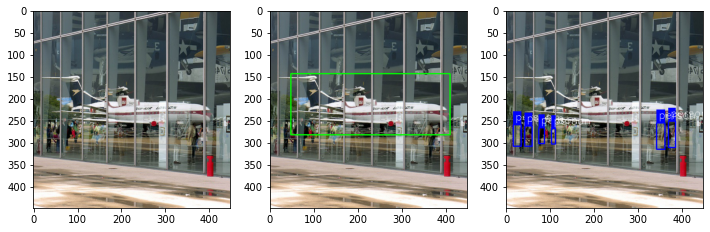

In [54]:
lots_of_prediction([100,102,41,55,67])

In [37]:
def lots_of_prediction_and_lots_of_model(label_index: list, model_list: list):
    
    num_col = 2+len(model_list)
    
    for i in label_index:
        testimg, labels = trainset[i]

        plt.figure(figsize=(30,30))

        plt.subplot(1,num_col,1)
        plt.title('original')
        copy_img = tensor2np_uint8(testimg)
        plt.imshow(copy_img)

        plt.subplot(1,num_col,2)
        plt.title('ground truth')
        copy_img = tensor2np_uint8(testimg)
        draw_label(copy_img, labels) 
        plt.imshow(copy_img)

        for mi, m in enumerate(model_list):
            model.load_state_dict(torch.load(m))

            testimgpred = model_predict(testimg)
            bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1)    
            best_index = nms(bbox_result[0,:,:4],bbox_result[0,:,4], nms_thres, conf_thres)

            plt.subplot(1,num_col,mi+3)
            plt.title(m)
            copy_img = tensor2np_uint8(testimg)
            draw_pred(copy_img, bbox_result, best_index, class_show=True)
            plt.imshow(copy_img)


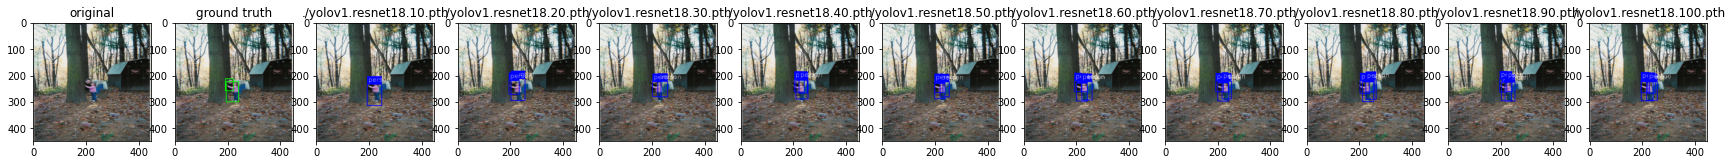

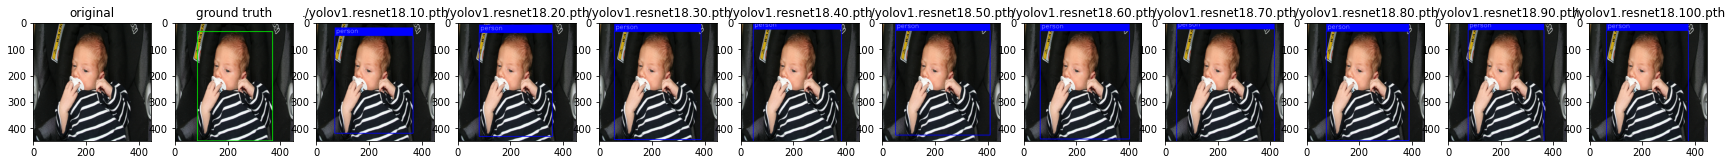

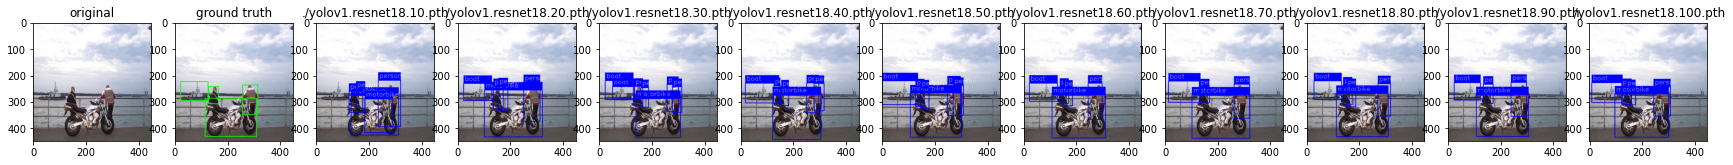

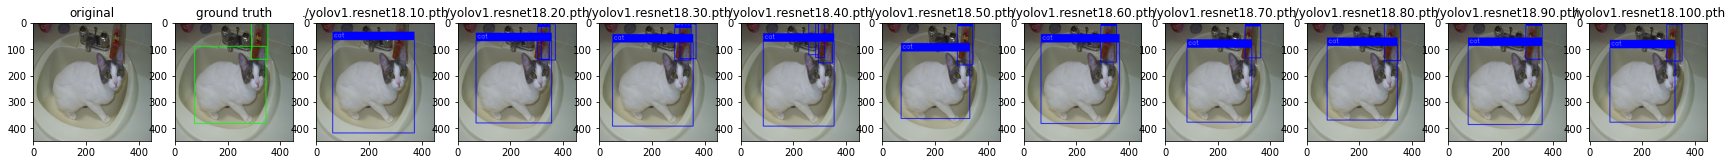

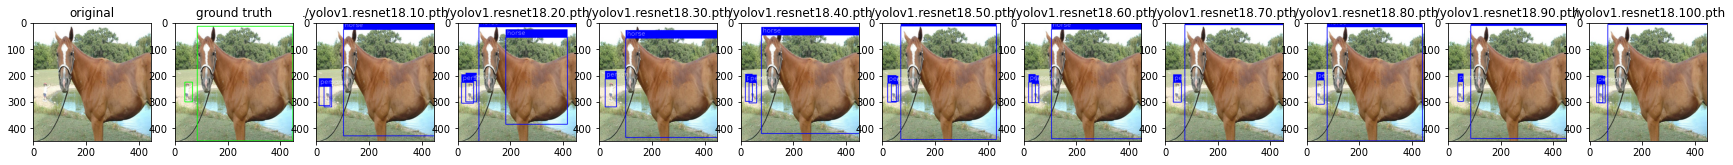

In [38]:
lots_of_prediction_and_lots_of_model([100,102,41,55,68],[f'./yolov1.{MODEL_BACKBONE}.{(i+1)*10}.pth' for i in range(10)])

# evaluation

In [59]:
testimg, labels = trainset[110]

a = time.time()
testimgpred = model_predict(testimg)
b = time.time()
bbox_result = yolov1_decode(testimgpred, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1)
c = time.time()
for class_idx in range(len(voc_classes)):
    best_index = nms(bbox_result[0,:,:4],bbox_result[0,:,4]*bbox_result[0,:,5+class_idx], nms_thres, conf_thres)
#     print(class_idx, len(best_index))
d = time.time()

print('inference time: ', b-a)
print('decode time: ', c-b)
print('nms time: ', d-c)

inference time:  0.02896857261657715
decode time:  0.0010001659393310547
nms time:  0.019002437591552734


In [39]:
def map_table(prediction: torch.Tensor, groundtruth: torch.Tensor, in_format: str = 'xywh') -> torch.Tensor:
    """produce iou and prob and gt num"""
    
    assert prediction.dim() == 2, 'the pred should be [N,4]'
    assert groundtruth.dim() == 2, 'the gt should be [M,4]'
    
    assert prediction.shape[1] == 5, 'coord 4 and prob 1'
    assert groundtruth.shape[1] == 4, 'coord 4'
    
    score = prediction[:,4] # ?
    
    if in_format == 'xywh':
        prediction = torchvision.ops.box_convert(prediction[:,:4],'xywh','xyxy')
        groundtruth = torchvision.ops.box_convert(groundtruth,'xywh','xyxy')
        
    # if many prediction overlapped with a ground truth, then best prediction left
    # if many groundtruth overlapped with a prediction, not matter
    
    ious = torchvision.ops.box_iou(prediction, groundtruth)
    iou_list, gt_index = ious.max(dim=1)
    iou_sort, iou_sort_index = iou_list.sort(descending=True)
    score = score[iou_sort_index]
    gt_index = gt_index[iou_sort_index]
    
    for i, ii in enumerate(gt_index):
        iou_sort[i+1:][gt_index[i+1:]==ii] = 0
        
    return iou_sort, score, groundtruth.size(0) # ? # ? # int

In [40]:
def mean_average_precision(table: List[tuple], iou_thres: float = 0.5) -> Tuple[List[float], List[float], float]:
    """for single class not the whole dataset"""
        
    total_gt_num = sum(gt_num for _, _, gt_num in table)
    
    ious = torch.cat([iou for iou, _, _ in table if iou is not None],0)
        
    prob = torch.cat([prob for _, prob, _ in table if prob is not None],0)  
    
    _, prob_index = prob.sort(descending=True)
    
    p = ious[prob_index]
    
    tp = p.gt(iou_thres).cumsum(0)
    
    precision = tp/torch.arange(1, tp.size(0)+1)
    recall = tp/total_gt_num
        
    auc = torch.trapz(precision,recall).item()
    
    return precision, recall, auc
    

In [41]:
def evaluate():
    
    MAP = {c: 0 for c in voc_classes}
    MAP_TABLE = {c: [] for c in voc_classes}
    
    # go through the dataset, not wise for big dataset
    for index, (img, label) in enumerate(tqdm(testloader)):
        # label, c,x,y,w,h
        # decode, x,y,w,h,c
        
        img = img.to(device)
        
        with torch.no_grad():
            model.eval()
            output = model(img).detach().cpu()
            img = img.detach().cpu()
        
        # recover gt coord in xywh
        label[:,3:5] = label[:,3:5]*IMAGE_SIZE # return w,h
        grid_x, grid_y = generate_grid((7,7))
        label[:,1] = label[:,1]*IMAGE_SIZE+grid_x*64-label[:,3]/2 # return x1
        label[:,2] = label[:,2]*IMAGE_SIZE+grid_y*64-label[:,4]/2 # return y1
        
        batch_decoded_output = yolov1_decode(output, (IMAGE_SIZE,IMAGE_SIZE), len(voc_classes), 1) # B, 98, 25
        
        for i in range(img.size(0)):
            single_label = label[i] # 25, 7, 7
            single_label = single_label.view(25,-1).transpose(0,1) # 49, 25
            single_label = single_label[single_label[:,0]==1] # ?, 25
            label_count = single_label[:,5:].sum(0)
            
            decoded_output = batch_decoded_output[i] # 98, 25
            cls_index = decoded_output[:,5:].argmax(1)
            
            for c in range(len(voc_classes)):
                no_detection = True
                this_class_detection = decoded_output[cls_index.eq(c)]
                if this_class_detection.size(0) != 0: 
                    class_prob = this_class_detection[:,4] * this_class_detection[:,5+c]
                    best_index = nms(this_class_detection[:,:4], class_prob,
                                     nms_thres, conf_thres)
                    
                    # if detection
                    if len(best_index) != 0: 
                        no_detection = False
                        this_class_detection = this_class_detection[best_index,:] # ?,25
                        this_class_label = single_label[single_label[:,5+c]==1,1:5]
                        # no class
                        if this_class_label.size(0) == 0:
                            tmp_table = (torch.zeros(len(best_index)), class_prob[best_index], 0)
                        # have class 
                        else:
                            tmp_table = map_table(torch.cat([this_class_detection[:,:4],class_prob[best_index].reshape(-1,1)],1), this_class_label)
          
                        MAP_TABLE[voc_classes[c]].append(tmp_table) # tuple
            
                # no detection
                if no_detection:
                    # have class
                    if label_count[c]:
                        tmp_table = (None, None, label_count[c].item())
                        MAP_TABLE[voc_classes[c]].append(tmp_table)
                            
                # check gt_num is correct
#                 if c == 0 and label_count[c]!=0:
#                     assert label_count[c]==tmp_table[2], f'{index,i}'
                
                
    
    # calculate pr curve and auc
    for c in voc_classes:
        MAP[c] = mean_average_precision(MAP_TABLE[c])
           
    return MAP, MAP_TABLE

In [41]:
conf_thres = 0.3 # the lower, the more boxes
nms_thres = 0.5 # the higher, the more boxes

In [ ]:
map_score = evaluate()

# Interpolated PR curve

In [42]:
def all_pr_curve(p:torch.Tensor, r:torch.Tensor) -> Tuple[torch.Tensor,torch.Tensor]:
    interpolated_precision = [p.max()]
    recall = [0]
    for i in r:
        tmp_p = p[r.gt(i)]
        if tmp_p.size(0) != 0: 
            interpolated_precision.append(tmp_p.max())
            recall.append(i)
        
    return torch.Tensor(interpolated_precision), torch.Tensor(recall)

# all epoch evaluation

In [43]:
# all model search
result = {}
for m in [f'yolov1.{MODEL_BACKBONE}.{(i+1)*10}.pth' for i in range(0,10)]:
    model.load_state_dict(torch.load(m))
    print(m)
    
    map_score, debug_map = evaluate()
    eval_table = pd.DataFrame(map_score,index=['precision','recall','AP@0.5'])    
    mAP = {c: 0 for c in voc_classes}
    for c in voc_classes:
        p, r = all_pr_curve(eval_table[c]['precision'], eval_table[c]['recall'])
        auc = torch.trapz(p,r).item()
        mAP[c] = auc
    result[m] = mAP

  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

yolov1.resnet18.10.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

yolov1.resnet18.20.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

yolov1.resnet18.30.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

yolov1.resnet18.40.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

yolov1.resnet18.50.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

yolov1.resnet18.60.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

yolov1.resnet18.70.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

yolov1.resnet18.80.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

yolov1.resnet18.90.pth


  0%|                                                                                          | 0/310 [00:00<?, ?it/s]

yolov1.resnet18.100.pth


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [01:17<00:00,  4.01it/s]


In [ ]:
# hyperparameter search
# result = {}

# for ct, nt in product([0.1,0.3,0.5],[0.3,0.5,0.7,0.9]):
#     conf_thres = ct
#     nms_thres = nt
#     for m in [f'yolov1.resnet18.{(i+1)*10}.pth' for i in range(9,10)]:
#         model.load_state_dict(torch.load(m))
#         print(m,ct,nt)
#         map_score = evaluate()
#         eval_table = pd.DataFrame(map_score,index=['precision','recall','AP@0.5'])    
#         mAP = {c: 0 for c in voc_classes}
#         for c in voc_classes:
#             p, r = eleven_point_pr_curve(eval_table[c]['precision'], eval_table[c]['recall'])
#             auc = torch.trapz(p,r).item()
#             mAP[c] = auc
#         result[f'{m},c:{conf_thres},n:{nms_thres}'] = mAP

In [333]:
# single model single parameter set
prefix = './convhead-1024.1e-4/'
result = {}
conf_thres = 0.3
nms_thres = 0.5
for m in [f'{prefix}yolov1.resnet18.{(i+1)*10}.pth' for i in range(10)]:
    model.load_state_dict(torch.load(m))
    print(m,conf_thres,nms_thres)
    map_score,  debug_map = evaluate()
    eval_table = pd.DataFrame(map_score,index=['precision','recall','AP@0.5'])    
    mAP = {c: 0 for c in voc_classes}
    for c in voc_classes:
        p, r = all_pr_curve(eval_table[c]['precision'], eval_table[c]['recall'])
        auc = torch.trapz(p,r).item()
        mAP[c] = auc
    result[f'{m},c:{conf_thres},n:{nms_thres}'] = mAP

  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

./convhead-1024.1e-4/yolov1.resnet18.10.pth 0.3 0.5


  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

./convhead-1024.1e-4/yolov1.resnet18.20.pth 0.3 0.5


  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

./convhead-1024.1e-4/yolov1.resnet18.30.pth 0.3 0.5


  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

./convhead-1024.1e-4/yolov1.resnet18.40.pth 0.3 0.5


  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

./convhead-1024.1e-4/yolov1.resnet18.50.pth 0.3 0.5


  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

./convhead-1024.1e-4/yolov1.resnet18.60.pth 0.3 0.5


  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

./convhead-1024.1e-4/yolov1.resnet18.70.pth 0.3 0.5


  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

./convhead-1024.1e-4/yolov1.resnet18.80.pth 0.3 0.5


  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

./convhead-1024.1e-4/yolov1.resnet18.90.pth 0.3 0.5


  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

./convhead-1024.1e-4/yolov1.resnet18.100.pth 0.3 0.5


100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [01:00<00:00,  2.55it/s]


In [44]:
cmap = [list(r.values())+[np.mean(list(r.values()))] for m,r in result.items()]
result_table = pd.DataFrame(cmap,columns=voc_classes+['all'],index=result.keys())
result_table

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,all
yolov1.resnet18.10.pth,0.449807,0.414056,0.361416,0.202379,0.125661,0.414519,0.449365,0.641229,0.115120,0.269431,...,0.518976,0.586533,0.427324,0.350872,0.070078,0.313889,0.350167,0.505395,0.255368,0.356478
yolov1.resnet18.20.pth,0.503964,0.454201,0.387516,0.197692,0.101097,0.363781,0.510002,0.565765,0.207195,0.335596,...,0.525325,0.529802,0.397140,0.390782,0.122860,0.323606,0.286517,0.443792,0.374114,0.361817
yolov1.resnet18.30.pth,0.494756,0.499315,0.424709,0.209959,0.094004,0.494222,0.526484,0.628424,0.185081,0.431601,...,0.559305,0.649583,0.462901,0.441498,0.100456,0.473161,0.302534,0.598236,0.437602,0.410353
yolov1.resnet18.40.pth,0.533833,0.447433,0.407184,0.195153,0.161801,0.407943,0.573234,0.637615,0.176120,0.378825,...,0.554125,0.661715,0.419462,0.446681,0.098621,0.419495,0.329780,0.543120,0.452163,0.407123
yolov1.resnet18.50.pth,0.589903,0.452400,0.480690,0.233768,0.160260,0.539454,0.582522,0.695736,0.222826,0.443192,...,0.580571,0.628048,0.402270,0.465911,0.150547,0.458315,0.422263,0.545292,0.440583,0.440703
yolov1.resnet18.60.pth,0.575709,0.545556,0.421409,0.300200,0.163143,0.498384,0.598042,0.654630,0.210966,0.441831,...,0.520611,0.612621,0.447578,0.472147,0.157415,0.458810,0.422118,0.563657,0.418693,0.442052
yolov1.resnet18.70.pth,0.527285,0.561575,0.458908,0.276210,0.166062,0.524547,0.585499,0.605648,0.233292,0.424100,...,0.548649,0.580020,0.479723,0.440516,0.181413,0.486936,0.385401,0.540096,0.437925,0.433275
yolov1.resnet18.80.pth,0.594138,0.531539,0.465828,0.276707,0.180416,0.485833,0.611277,0.660786,0.201586,0.422531,...,0.594524,0.652663,0.526579,0.480667,0.163611,0.388508,0.397609,0.547898,0.422035,0.443586
yolov1.resnet18.90.pth,0.549719,0.455837,0.462621,0.238947,0.205223,0.476644,0.593223,0.582057,0.217988,0.488059,...,0.568401,0.649946,0.555073,0.500655,0.159024,0.468419,0.340583,0.511816,0.462970,0.436635
yolov1.resnet18.100.pth,0.581778,0.588035,0.474560,0.334351,0.206726,0.615785,0.599861,0.643023,0.245792,0.424694,...,0.596044,0.619597,0.489911,0.483113,0.185256,0.462127,0.329231,0.652201,0.454741,0.461635


In [63]:
result_table.loc[f'yolov1.{MODEL_BACKBONE}.100.pth']

aeroplane      0.581778
bicycle        0.588035
bird           0.474560
boat           0.334351
bottle         0.206726
bus            0.615785
car            0.599861
cat            0.643023
chair          0.245792
cow            0.424694
diningtable    0.245872
dog            0.596044
horse          0.619597
motorbike      0.489911
person         0.483113
pottedplant    0.185256
sheep          0.462127
sofa           0.329231
train          0.652201
tvmonitor      0.454741
all            0.461635
Name: yolov1.resnet34.100.pth, dtype: float64

In [65]:
result_table.to_csv('./eval.csv')

<AxesSubplot:>

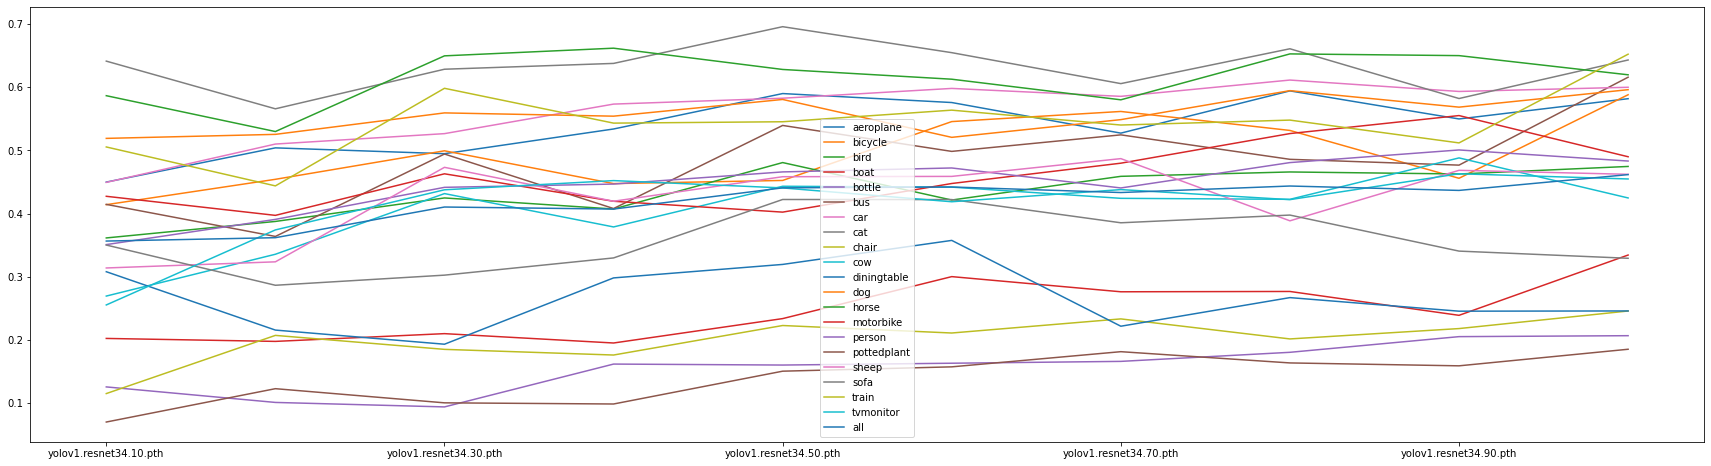

In [66]:
result_table.plot(figsize=(30,8))

<AxesSubplot:title={'center':'validation mAP on VOC 2007 test set'}>

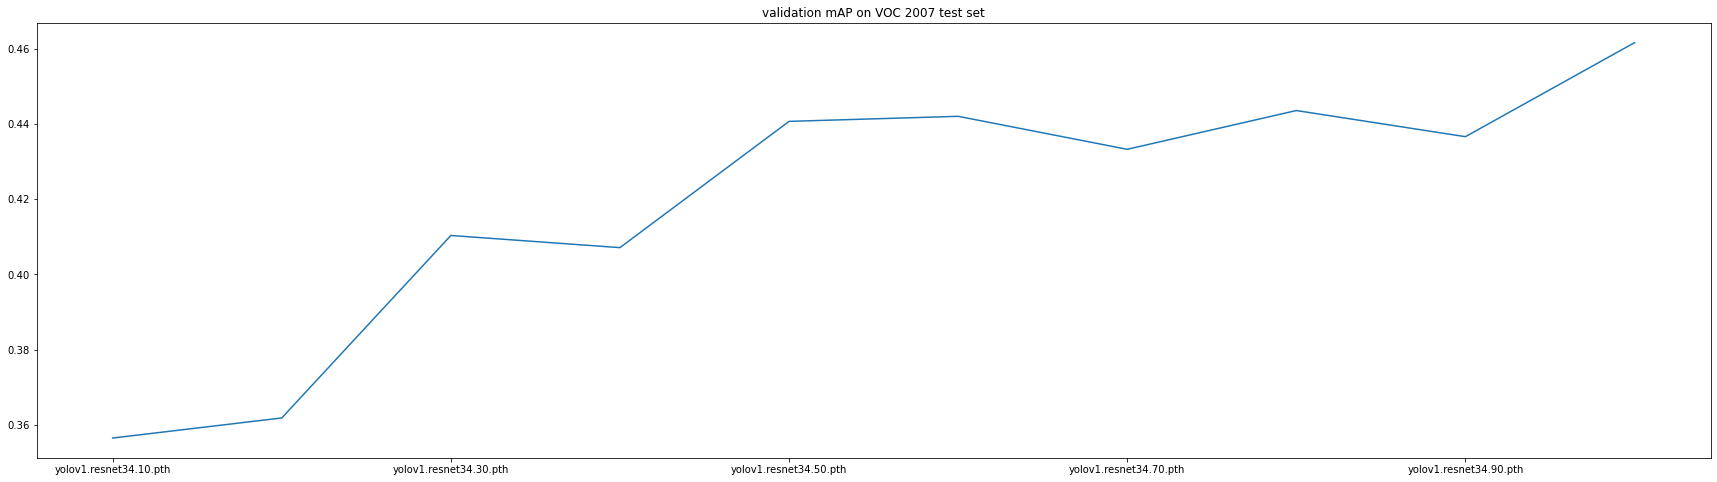

In [64]:
result_table['all'].plot(figsize=(30,8),title="validation mAP on VOC 2007 test set")

# debug

In [331]:
gt_num = 0
for _, label in tqdm(testloader):
    gt_num += label[:,5:,:,:].sum((0,2,3))

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:29<00:00,  5.27it/s]


In [332]:
{c:g.item() for c, g in zip(voc_classes,gt_num)}

{'aeroplane': 265.0,
 'bicycle': 333.0,
 'bird': 450.0,
 'boat': 256.0,
 'bottle': 405.0,
 'bus': 212.0,
 'car': 1161.0,
 'cat': 358.0,
 'chair': 728.0,
 'cow': 238.0,
 'diningtable': 206.0,
 'dog': 488.0,
 'horse': 343.0,
 'motorbike': 317.0,
 'person': 4205.0,
 'pottedplant': 459.0,
 'sheep': 232.0,
 'sofa': 238.0,
 'train': 282.0,
 'tvmonitor': 305.0}

In [48]:
interest_cls = 'aeroplane'
Iamnotsure = pd.DataFrame({
    'iou': torch.cat([a for a, b, c in debug_map[interest_cls] if a is not None],0).numpy(),
    'prob': torch.cat([b for a, b, c in debug_map[interest_cls] if b is not None],0).numpy(),
    'gt': sum(c for a, b, c in debug_map[interest_cls])
}).sort_values('prob',ascending=False)
Iamnotsure['TP'] = Iamnotsure['iou'].gt(0.5).cumsum()
Iamnotsure['precision'] = Iamnotsure['TP']/np.arange(1,len(Iamnotsure)+1)
Iamnotsure['recall'] = Iamnotsure['TP']/Iamnotsure['gt']
Iamnotsure

,iou,prob,gt,TP,precision,recall
171,0.743858,0.953602,265.0,1,1.000000,0.003774
13,0.536036,0.951498,265.0,2,1.000000,0.007547
208,0.983879,0.950003,265.0,3,1.000000,0.011321
143,0.889778,0.943915,265.0,4,1.000000,0.015094
5,0.767990,0.942085,265.0,5,1.000000,0.018868
...,...,...,...,...,...,...
209,0.022067,0.369044,265.0,161,0.755869,0.607547
46,0.911872,0.357704,265.0,162,0.757009,0.611321
138,0.000000,0.354245,265.0,162,0.753488,0.611321
136,0.499191,0.338363,265.0,162,0.750000,0.611321


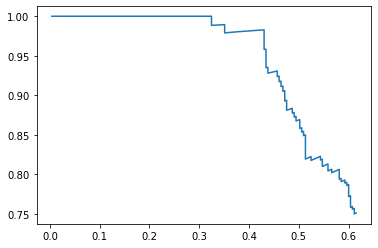

In [49]:
plt.plot(Iamnotsure['recall'], Iamnotsure['precision'])

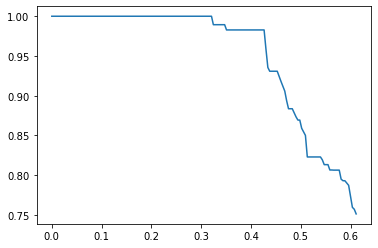

In [50]:
a,b = all_pr_curve(eval_table[interest_cls]['precision'],eval_table[interest_cls]['recall'])
plt.plot(b, a)